In [1]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get a stock data

In [2]:
# define tricker symbol
tickerSymbol = "AAPL" # can use other company tickers

#get data on this sticker
tickerData = yf.Ticker(tickerSymbol)
# get historical price for this ticker
tickerDf = tickerData.history(period = '1mo', start = '2010-1-1', end = '2020-1-25')

tickerDf
#tickerData.info

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,6.522158,6.554855,6.490071,6.539882,493729600,0.0,0.0
2010-01-05,6.557910,6.588163,6.516656,6.551187,601904800,0.0,0.0
2010-01-06,6.551189,6.577164,6.440261,6.446983,552160000,0.0,0.0
2010-01-07,6.470819,6.478459,6.388311,6.435065,477131200,0.0,0.0
2010-01-08,6.426508,6.478458,6.388615,6.477847,447610800,0.0,0.0
...,...,...,...,...,...,...,...
2020-01-17,77.753908,78.361149,77.441685,78.358696,137816400,0.0,0.0
2020-01-21,77.980091,78.429987,77.687533,77.827667,110843200,0.0,0.0
2020-01-22,78.321815,78.668460,78.009593,78.105476,101832400,0.0,0.0


In [3]:
data = tickerDf.iloc[:,1]
data.head(), data.shape

(Date
 2010-01-04    6.554855
 2010-01-05    6.588163
 2010-01-06    6.577164
 2010-01-07    6.478459
 2010-01-08    6.478458
 Name: High, dtype: float64,
 (2532,))

In [4]:
data = data.to_frame()
data.head()

,High
Date,
2010-01-04,6.554855
2010-01-05,6.588163
2010-01-06,6.577164
2010-01-07,6.478459
2010-01-08,6.478458


Here, we have a univariate data set which records the number of airline passengers for each month.

Let's now plot the time series of the data in order to get some ideas about underlying trends, seasonality etc.

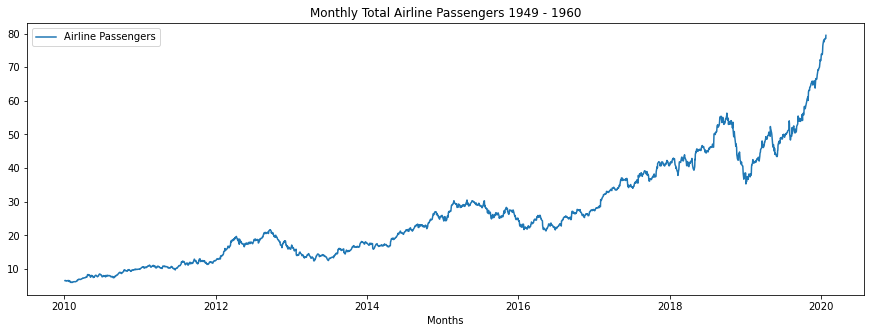

In [5]:
# Create a time series plot.
plt.figure(figsize = (15, 5)) # plot size
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months") # add axis title
plt.ylabel("") # add axis title
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

Decompose data see if trend/seasonality trend exists

C:\Users\Lenovo\Anaconda3\envs\TENSORFLOWSESSION\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys


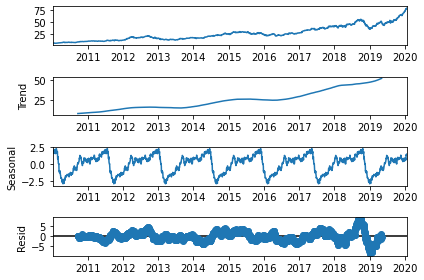

In [6]:
import statsmodels.api as sm

#dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
#dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(data, freq = 365)
resplot = res.plot()

### Building the LSTM model


In [8]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


#### Data preparation

In [9]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32") # convert data type

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
#dataset[0:5], data_raw[0:5],data[0:5]

#### Split into test / training data

As usual, the data gets split into training and test data so we can later assess how well the final model performs. 

Again, this could be much improved, e.g. using CV and more sophisticated steps to select the "best" model.

In [10]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.70
# splitting training/testing ddata is different from other model
# in time series data, split based on the time order of the order because we need to keep the time sequence
## use more recent data as test and historical data as train
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :] # split at a certain time point
print("Number of entries (training set, test set): " + str((len(train), len(test))))


Number of entries (training set, test set): (1772, 760)


#### Get data into shape to use in Keras

In [11]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
# this function is to help construct data as x variables (which is past data depend on how many time step you want to go back) and y variable (as the time step you want to predict)
def create_dataset(dataset, window_size = 3):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))
# result in the dataset has 2 observations than waht it suppose to be

In [12]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras. reshape(number of samples, time steps,number of features at each time step)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)
print(test_X.shape)

Original training data shape:
(1770, 1)
New training data shape:
(1770, 1, 1)
(758, 1, 1)


#### Build simple LSTM model on training data

The LSTM architecture here consists of:

* One input layer.
* One LSTM layer of 4 blocks.
* One `Dense` layer to produce a single output.
* Use MSE as loss function.

Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

Parameters meaning:
input_shape: (time steps, number of feature at each time step)
optimizer: algorithm in optimizing loss function to get coefficient
epochs: number of times that the entire dataset pass forward through the model
batch_size: amount of sample used in each iteration
verbose: print out performance in each epoch or not

In [13]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential() # model for LSTM
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size))) # add a layer for LSTM, 4 neuros in the LSTM layer
    model.add(Dense(1)) # dense layer to return the output, number of output for each observation is 1
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam") # loss function and optimizer
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2) # fit model
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
 - 5s - loss: 0.0058
Epoch 2/100
 - 4s - loss: 1.0372e-04
Epoch 3/100
 - 4s - loss: 2.0960e-05
Epoch 4/100
 - 4s - loss: 1.9781e-05
Epoch 5/100
 - 4s - loss: 1.8381e-05
Epoch 6/100
 - 4s - loss: 1.7763e-05
Epoch 7/100
 - 4s - loss: 1.7382e-05
Epoch 8/100
 - 3s - loss: 1.6437e-05
Epoch 9/100
 - 3s - loss: 1.7551e-05
Epoch 10/100
 - 3s - loss: 1.6558e-05
Epoch 11/100
 - 4s - loss: 1.6570e-05
Epoch 12/100
 - 3s - loss: 1.6415e-05
Epoch 13/100
 - 3s - loss: 1.6669e-05
Epoch 14/100
 - 3s - loss: 1.6137e-05
Epoch 15/100
 - 3s - loss: 1.6505e-05
Epoch 16/100
 - 3s - loss: 1.6244e-05
Epoch 17/100
 - 3s - loss: 1.6406e-05
Epoch 18/100
 - 3s - loss: 1.6427e-05
Epoch 19/100
 - 3s - loss: 1.6983e-05
Epoch 20/100
 - 3s - loss: 1.6339e-05
Epoch 21/100
 - 3s - loss: 1.5895e-05
Epoch 22/100
 - 3s - loss: 1.6580e-05
Epoch 23/100
 - 4s - loss: 1.6489e-05
Epoch 24/100
 - 3s - loss: 1.7151e-05
Epoch 25/100
 - 4s - loss: 1.7044e-05
Epoch 26/100
 - 3s - loss: 1.6025e-05
Epoch 27/100
 - 3s - loss

### Results
#### Predictions and model evaluation

As can be seen below, already the simple model performs not too poorly. The advantage of using the RMSE is that it's in the same unit as the original data, i.e. 1.000 passengers / month.

In [14]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# before detrend, training error is 21.84 and test error is 44.99

Training data score: 0.26 RMSE
Test data score: 3.97 RMSE


#### Plotting original data, predictions, and forecast

With a plot we can compare the predicted vs. actual passenger figures.

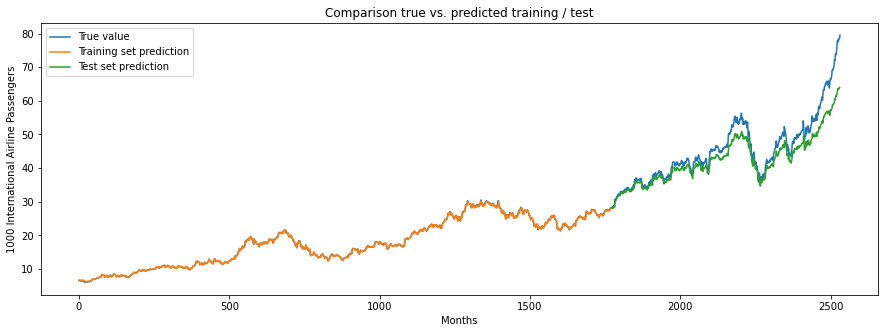

In [16]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

https://towardsdatascience.com/performing-a-time-series-analysis-on-the-aapl-stock-index-3655da9612ff